# Imports

In [44]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# 1. Dataset Preparation & Analysis

## 1.2 - Loading the dataset

In [45]:
data = pd.read_csv("../SOEN-471-Music-Recommender-System/data/data.csv")
genre_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_genres.csv')
year_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_year.csv')

## 1.3 - Data Exploration

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [47]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [48]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


## 1.4 - Data Visualisation

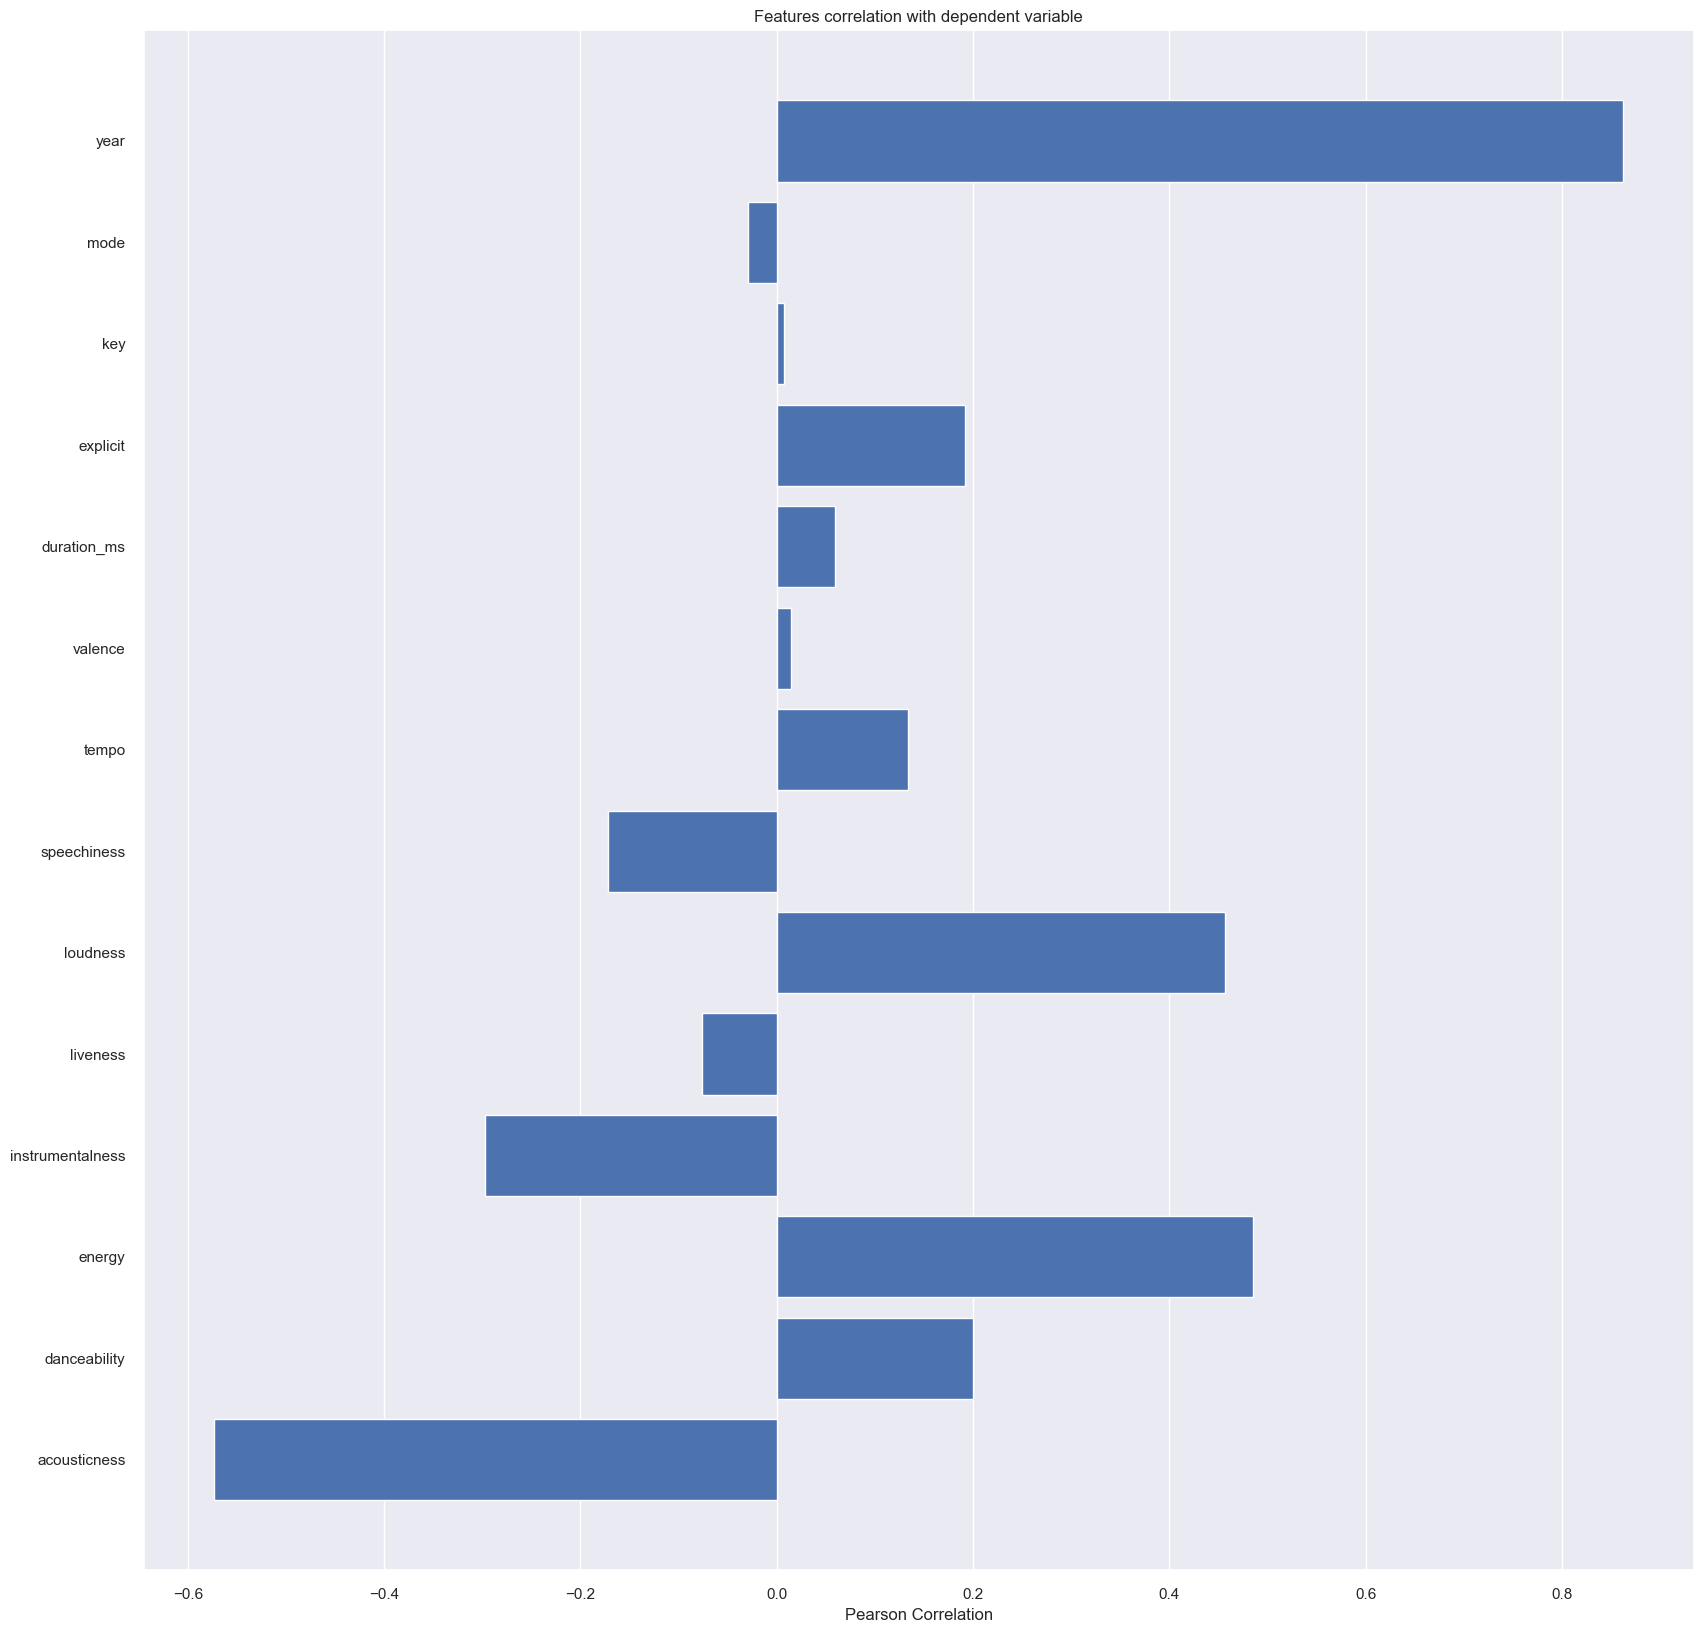

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [49]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']
features = np.array(feature_names)
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     
visualizer.show()

In [50]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
fig = px.line(year_data, x='year', y=sound_features, title='Trend of sound features over decades')
fig.show()

In [51]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'], barmode='group',
            title='Characteristics of top 10 genres')
fig.show()

## 1.5 - Data Transformation

In [52]:
df = data.drop(columns=['id', 'name', 'artists', 'release_date', 'year'])
df.corr()

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
valence,1.000000,-0.184101,0.558946,-0.191813,0.353876,-0.018613,-0.198501,0.028473,0.003832,0.313512,0.015641,0.014200,0.046381,0.171689
acousticness,-0.184101,1.000000,-0.266852,-0.076373,-0.749393,-0.246007,0.329819,-0.020550,-0.024482,-0.561696,0.047168,-0.573162,-0.043980,-0.207120
danceability,0.558946,-0.266852,1.000000,-0.139937,0.221967,0.241757,-0.278063,0.024439,-0.100193,0.285057,-0.045956,0.199606,0.235491,0.001801
duration_ms,-0.191813,-0.076373,-0.139937,1.000000,0.042119,-0.048880,0.084770,-0.004266,0.047168,-0.003037,-0.046085,0.059597,-0.084604,-0.025472
energy,0.353876,-0.749393,0.221967,0.042119,1.000000,0.132723,-0.281101,0.027705,0.126192,0.782362,-0.039260,0.485005,-0.070555,0.250865
explicit,-0.018613,-0.246007,0.241757,-0.048880,0.132723,1.000000,-0.140987,0.005432,0.039640,0.140300,-0.078872,0.191543,0.414070,0.011969
instrumentalness,-0.198501,0.329819,-0.278063,0.084770,-0.281101,-0.140987,1.000000,-0.014591,-0.047193,-0.408611,-0.036543,-0.296750,-0.121700,-0.105361
key,0.028473,-0.020550,0.024439,-0.004266,0.027705,0.005432,-0.014591,1.000000,0.000205,0.017385,-0.116260,0.007826,0.023784,0.002629
liveness,0.003832,-0.024482,-0.100193,0.047168,0.126192,0.039640,-0.047193,0.000205,1.000000,0.056422,0.002641,-0.076464,0.134667,0.007714
loudness,0.313512,-0.561696,0.285057,-0.003037,0.782362,0.140300,-0.408611,0.017385,0.056422,1.000000,-0.010727,0.457051,-0.139296,0.209774


In [53]:
feature_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'valence',]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_df =scaler.fit_transform(df[feature_cols])

print(normalized_df[:2])

[[0.98594378 0.28238866 0.15311207 0.211      0.878      0.90909091
  0.665      0.62491582 1.         0.03773196 0.3324504  0.0594    ]
 [0.73493976 0.82894737 0.03249579 0.341      0.         0.63636364
  0.16       0.74479681 1.         0.42783505 0.25024332 0.963     ]]
